## Detailed Analysis
### GAIA Star Cluster Member Classification    
#### DATA 301, 2023

**Sakila Wanigasinghe [300526406]**

***

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier, plot_importance
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, precision_score, balanced_accuracy_score, recall_score, f1_score, plot_roc_curve
from sklearn.preprocessing import LabelEncoder

<br>

**Loading in data for star clusters: *NGC 7789*, and *Trumpler 5***

In [2]:
## Loading in NGC 7789 star cluster data
ngc_7789 = pd.read_csv('../Data/ngc_7789.csv')
ngc_7789.shape

(3575, 13)

In [3]:
ngc_7789.head()

,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,radial_velocity,teff_gspphot,Cluster
0,420901507912889088,0.082375,56.014056,0.320644,-0.386428,-1.528307,16.820808,17.286600,16.184370,1.102230,NaN,5409.3820,Other
1,420906936751548288,0.237080,56.055887,0.597838,-1.651632,-2.148538,17.591908,18.355732,16.755722,1.600010,NaN,4343.0300,Other
2,420907142909967104,0.149607,56.061129,0.211846,-1.312115,-2.421624,15.102909,15.690556,14.344952,1.345604,NaN,5978.2773,Other
3,420907722722130816,0.003523,56.075048,0.342945,-1.708469,-2.459792,16.090326,16.448742,15.559808,0.888934,NaN,6960.6714,Other
4,420908414210912512,0.013300,56.152271,0.560820,-1.245880,-2.100259,16.771912,NaN,NaN,NaN,NaN,NaN,Other


In [4]:
## Loading in Trumpler 5 star cluster data
trumpler_5 = pd.read_csv('../Data/trumpler_5.csv')
trumpler_5.shape

(3302, 13)

In [5]:
trumpler_5.head()

,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,radial_velocity,teff_gspphot,Cluster
0,3326188665921045120,99.180263,8.938090,0.117289,-0.767038,0.202383,17.720343,18.314255,16.970951,1.343304,NaN,5201.7600,Other
1,3326188940798945920,99.123816,8.924983,-0.052569,0.351594,-0.838942,17.792180,18.782574,16.812962,1.969612,NaN,4615.8970,Other
2,3326189391771063424,99.161032,8.937259,0.354193,-0.229926,-0.055456,16.855852,17.416264,16.147139,1.269125,NaN,5466.8804,Other
3,3326189421835294080,99.175908,8.955257,0.423364,0.278428,-0.069258,17.581598,18.265062,16.802801,1.462261,NaN,5164.1900,Other
4,3326189593633986432,99.104969,8.958145,0.333585,-0.597968,-0.295040,17.811178,18.439910,17.031984,1.407927,NaN,4466.0156,Other


<br>

### NGC 7789 Star Cluster Members Classification

**Creating train, validation, and test sets**

In [6]:
ngc_7789_filtered = ngc_7789.copy()

In [62]:
ngc_7789[ngc_7789['ra'] < 350] 

,source_id,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,radial_velocity,teff_gspphot,Cluster
0,420901507912889088,0.082375,56.014056,0.320644,-0.386428,-1.528307,16.820808,17.286600,16.184370,1.102230,NaN,5409.3820,Other
1,420906936751548288,0.237080,56.055887,0.597838,-1.651632,-2.148538,17.591908,18.355732,16.755722,1.600010,NaN,4343.0300,Other
2,420907142909967104,0.149607,56.061129,0.211846,-1.312115,-2.421624,15.102909,15.690556,14.344952,1.345604,NaN,5978.2773,Other
3,420907722722130816,0.003523,56.075048,0.342945,-1.708469,-2.459792,16.090326,16.448742,15.559808,0.888934,NaN,6960.6714,Other
4,420908414210912512,0.013300,56.152271,0.560820,-1.245880,-2.100259,16.771912,NaN,NaN,NaN,NaN,NaN,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,422583034844602112,0.355194,57.279634,0.412508,-0.631639,-2.461907,17.302150,17.849550,16.550047,1.299503,NaN,5124.4320,Other
260,422583657623854720,0.347800,57.330223,0.355430,-1.006360,-1.968413,16.235216,16.875200,15.459732,1.415468,NaN,6661.4546,NGC_7789
261,422583863782273536,0.304497,57.351383,0.548345,-0.603432,-1.447743,16.439352,17.027962,15.703833,1.324129,NaN,5350.5430,Other
262,422587437195037312,0.126471,57.370982,0.442180,-0.529464,-1.374898,16.746067,17.501043,15.895293,1.605750,NaN,5229.0825,Other


In [7]:
## Removing redundant column 'source_id' and 'radial_velocity'
ngc_7789_filtered = ngc_7789[ngc_7789['ra'] > 350]
ngc_7789_filtered = ngc_7789_filtered.drop(['radial_velocity', 'source_id'], axis = 1)
ngc_7789_filtered.shape

(3311, 11)

In [8]:
ngc_7789_filtered.head()

,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,teff_gspphot,Cluster
264,359.973766,55.980510,0.345684,-1.264863,-2.185392,17.272950,17.700705,16.653336,1.047369,5222.2837,Other
265,359.800712,55.948081,0.476470,-0.785729,-1.906318,17.525180,18.180155,16.755987,1.424168,4296.6250,NGC_7789
266,359.931384,56.017455,0.454876,-1.166511,-1.637231,17.030367,17.451424,16.395910,1.055513,5608.1465,Other
267,359.458759,55.896147,0.480959,-1.395051,-1.462129,17.948677,18.468685,17.260397,1.208288,4736.8400,Other
268,359.498434,55.904656,0.258754,-0.458683,-2.072979,17.734300,18.214066,17.100204,1.113861,4929.7090,Other


In [9]:
## Creating train and test sets
ngc_train_val, ngc_test = train_test_split(ngc_7789_filtered, test_size = 0.20, random_state = 309)
print(ngc_train_val.shape, ngc_test.shape)

(2648, 11) (663, 11)


In [10]:
## Creating validation set from training set
ngc_train, ngc_val = train_test_split(ngc_train_val, test_size = 0.20, random_state = 309)
print(ngc_train.shape, ngc_val.shape)

(2118, 11) (530, 11)


In [11]:
## Splitting train, test, and validation sets into corresponding X and y
target = 'Cluster'
ngc_X_train = ngc_train.drop(target, axis = 1) 
ngc_y_train = ngc_train[target].copy() 

ngc_X_val = ngc_val.drop(target, axis = 1) 
ngc_y_val = ngc_val[target].copy() 

ngc_X_test = ngc_test.drop(target, axis = 1) 
ngc_y_test = ngc_test[target].copy() 

print(ngc_X_train.shape, ngc_y_train.shape, ngc_X_val.shape, ngc_y_val.shape, ngc_X_test.shape, ngc_y_test.shape)

(2118, 10) (2118,) (530, 10) (530,) (663, 10) (663,)


**Model Fitting and Preprocessing Function (Pipeline)**

In [12]:
def ngc_xgb_transform(X, y):
    '''XGBoost preprocessing and model fitting custom function for NGC 7789 data'''
    
    numerical_columns = ["ra", "dec", "parallax", "pmra", "pmdec", "phot_g_mean_mag", "phot_bp_mean_mag", "phot_rp_mean_mag", "bp_rp", "teff_gspphot"]

    numerical_preprocessor = Pipeline([('scaler', StandardScaler()),
                                       ('imputer', SimpleImputer(strategy = 'median'))])

    preprocessor = ColumnTransformer([
        ('scaler-and-imputer', numerical_preprocessor, numerical_columns),
    ])

    xgb_label_encoder = LabelEncoder()
    y = xgb_label_encoder.fit_transform(y)

    xgb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(objective = 'binary:logistic', random_state = 309))
    ])

    model = xgb_pipeline.fit(X, y)

    return(model, xgb_label_encoder)

**Model Evaluation Function**

In [13]:
## Defining custom function to evaluate model performance
def model_performance(model, X, y, label_enc, predictions = False):
    '''Generates performance metrics for the model, also can produce graphs of the model performance'''

    y_predicted = model.predict(X)

    y = label_enc.transform(y)
    y_predicted = model.predict(X) 
    y_predicted = label_enc.inverse_transform(y_predicted)
    
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 309)
    
    scores_RA = cross_val_score(model, X, y, cv = cv, scoring = "roc_auc")
    scores_BA = cross_val_score(model, X, y, cv = cv, scoring = "average_precision")    
        
    print(f"AUC-ROC: {scores_RA.mean():.4f} +/- {scores_RA.std():.4f}")
    print(f"AUC_PR: {scores_BA.mean():.4f} +/- {scores_BA.std():.4f}")

    if predictions == True:
        return(y_predicted)

**XGBoost model training and evaluation**

Using all features

In [14]:
## Performance of model on training data
ngc_xgb_model = ngc_xgb_transform(ngc_X_train, ngc_y_train)
model_performance(ngc_xgb_model[0], ngc_X_train, ngc_y_train, label_enc = ngc_xgb_model[1])

AUC-ROC: 0.9023 +/- 0.0094
AUC_PR: 0.8790 +/- 0.0127


In [15]:
## Performance of model on validation data
model_performance(ngc_xgb_model[0], ngc_X_val, ngc_y_val, label_enc = ngc_xgb_model[1])

AUC-ROC: 0.9178 +/- 0.0168
AUC_PR: 0.8956 +/- 0.0269


Removing all correlated features, except *phot_g_mean_mag*

In [16]:
## Fitting model, removing correlated features
def ngc_xgb_transform_2(X, y):
    '''XGBoost preprocessing and model fitting custom function for NGC 7789 data'''
    
    numerical_columns = ["ra", "dec", "parallax", "pmra", "pmdec", "phot_g_mean_mag"]

    numerical_preprocessor = Pipeline([('scaler', StandardScaler()),
                                       ('imputer', SimpleImputer(strategy = 'median'))])

    preprocessor = ColumnTransformer([
        ('scaler-and-imputer', numerical_preprocessor, numerical_columns),
    ])

    xgb_label_encoder = LabelEncoder()
    y = xgb_label_encoder.fit_transform(y)

    xgb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(objective = 'binary:logistic', random_state = 309))
    ])

    model = xgb_pipeline.fit(X, y)

    return(model, xgb_label_encoder)

In [17]:
ngc_X_train_2 = ngc_X_train.drop(["phot_bp_mean_mag", "phot_rp_mean_mag", "bp_rp", "teff_gspphot"], axis = 1)
ngc_X_val_2 = ngc_X_val.drop(["phot_bp_mean_mag", "phot_rp_mean_mag", "bp_rp", "teff_gspphot"], axis = 1)

In [18]:
## Performance of model on training data
ngc_xgb_model_2 = ngc_xgb_transform_2(ngc_X_train_2, ngc_y_train)
model_performance(ngc_xgb_model_2[0], ngc_X_train_2, ngc_y_train, label_enc = ngc_xgb_model_2[1])

AUC-ROC: 0.9040 +/- 0.0122
AUC_PR: 0.8789 +/- 0.0171


In [19]:
## Performance of model on validation data
model_performance(ngc_xgb_model_2[0], ngc_X_val_2, ngc_y_val, label_enc = ngc_xgb_model_2[1])

AUC-ROC: 0.9137 +/- 0.0150
AUC_PR: 0.8949 +/- 0.0209


Removing all correlated features, except *phot_g_mean_mag* and *teff_gspphot*

In [20]:
## Fitting model, removing correlated features
def ngc_xgb_transform_3(X, y):
    '''XGBoost preprocessing and model fitting custom function for NGC 7789 data'''
    
    numerical_columns = ["ra", "dec", "parallax", "pmra", "pmdec", "phot_g_mean_mag", "teff_gspphot"]

    numerical_preprocessor = Pipeline([('scaler', StandardScaler()),
                                       ('imputer', SimpleImputer(strategy = 'median'))])

    preprocessor = ColumnTransformer([
        ('scaler-and-imputer', numerical_preprocessor, numerical_columns),
    ])

    xgb_label_encoder = LabelEncoder()
    y = xgb_label_encoder.fit_transform(y)

    xgb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(objective = 'binary:logistic', random_state = 309))
    ])

    model = xgb_pipeline.fit(X, y)

    return(model, xgb_label_encoder)

In [21]:
ngc_X_train_3 = ngc_X_train.drop(["phot_bp_mean_mag", "phot_rp_mean_mag", "bp_rp"], axis = 1)
ngc_X_val_3 = ngc_X_val.drop(["phot_bp_mean_mag", "phot_rp_mean_mag", "bp_rp"], axis = 1)

In [22]:
## Performance of model on training data
ngc_xgb_model_3 = ngc_xgb_transform_3(ngc_X_train_3, ngc_y_train)
model_performance(ngc_xgb_model_3[0], ngc_X_train_3, ngc_y_train, label_enc = ngc_xgb_model_3[1])

AUC-ROC: 0.9045 +/- 0.0133
AUC_PR: 0.8840 +/- 0.0162


In [23]:
## Performance of model on validation data
model_performance(ngc_xgb_model_3[0], ngc_X_val_3, ngc_y_val, label_enc = ngc_xgb_model_3[1])

AUC-ROC: 0.9165 +/- 0.0145
AUC_PR: 0.8929 +/- 0.0175


<br>

**Tuning XGB Model 2**

In [24]:
numerical_columns = ["ra", "dec", "parallax", "pmra", "pmdec", "phot_g_mean_mag"]

numerical_preprocessor = Pipeline([('scaler', StandardScaler()),
                                    ('imputer', SimpleImputer(strategy = 'median'))])

preprocessor = ColumnTransformer([
    ('scaler-and-imputer', numerical_preprocessor, numerical_columns),
])

xgb_label_encoder = LabelEncoder()
ngc_y_train_enc = xgb_label_encoder.fit_transform(ngc_y_train)

xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(objective = 'binary:logistic', random_state = 309))
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.1, 0.01, 0.001]
}

gridSearch = GridSearchCV(xgb_model, param_grid, cv = 5, scoring = 'roc_auc', return_train_score = True)
gridSearch.fit(ngc_X_train_2, ngc_y_train_enc)

print("Best parameters:", gridSearch.best_params_)
tuned_xgb_model = gridSearch.best_estimator_

Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}


In [25]:
## Model performance on validation set
model_performance(tuned_xgb_model, ngc_X_val_2, ngc_y_val, label_enc = xgb_label_encoder)

AUC-ROC: 0.9235 +/- 0.0112
AUC_PR: 0.9047 +/- 0.0183


In [26]:
ngc_X_test_2 = ngc_X_test.drop(["phot_bp_mean_mag", "phot_rp_mean_mag", "bp_rp", "teff_gspphot"], axis = 1)

In [27]:
## Model performance on test set
model_performance(tuned_xgb_model, ngc_X_test_2, ngc_y_test, label_enc = xgb_label_encoder)

AUC-ROC: 0.8890 +/- 0.0321
AUC_PR: 0.8574 +/- 0.0365


In [28]:
## Model performance on test set, after training on train and validation sets
ngc_X_train_val = ngc_train_val.drop(target, axis = 1) 
ngc_y_train_val = ngc_train_val[target].copy() 
ngc_X_train_val_2 = ngc_X_train_val.drop(["phot_bp_mean_mag", "phot_rp_mean_mag", "bp_rp", "teff_gspphot"], axis = 1)

numerical_columns = ["ra", "dec", "parallax", "pmra", "pmdec", "phot_g_mean_mag"]

numerical_preprocessor = Pipeline([('scaler', StandardScaler()),
                                    ('imputer', SimpleImputer(strategy = 'median'))])

preprocessor = ColumnTransformer([
    ('scaler-and-imputer', numerical_preprocessor, numerical_columns),
])

xgb_label_encoder = LabelEncoder()
ngc_y_train_val_enc = xgb_label_encoder.fit_transform(ngc_y_train_val)

xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(objective = 'binary:logistic', random_state = 309))
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.1, 0.01, 0.001]
}

gridSearch = GridSearchCV(xgb_model, param_grid, cv = 5, scoring = 'roc_auc', return_train_score = True)
gridSearch.fit(ngc_X_train_val_2, ngc_y_train_val_enc)

print("Best parameters:", gridSearch.best_params_)
tuned_xgb_model = gridSearch.best_estimator_

Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}


In [29]:
tuned_perf = model_performance(tuned_xgb_model, ngc_X_test_2, ngc_y_test, label_enc = xgb_label_encoder, predictions = True)

AUC-ROC: 0.8890 +/- 0.0321
AUC_PR: 0.8574 +/- 0.0365


<br>

**Visualisations**

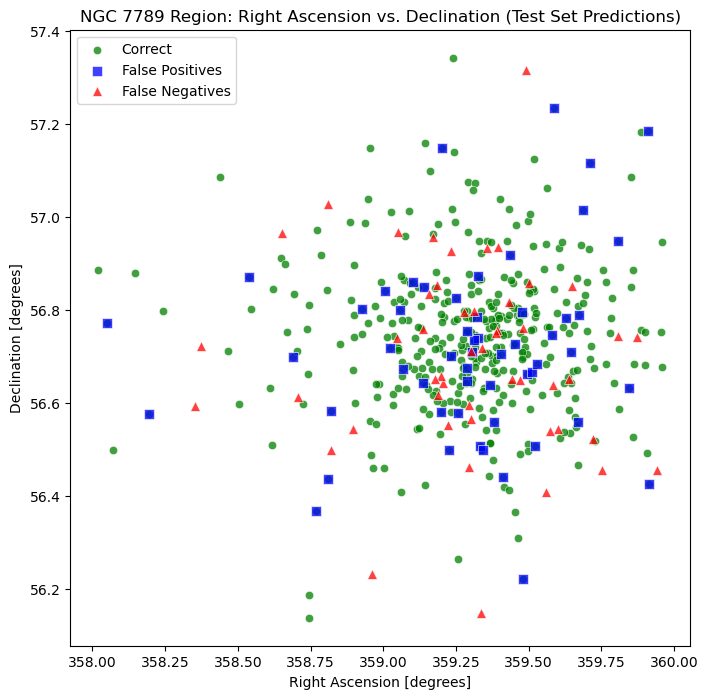

In [30]:
model_predictions = xgb_label_encoder.fit_transform(tuned_perf)
ngc_y_test_enc = xgb_label_encoder.fit_transform(ngc_y_test)

predictions_data = pd.DataFrame({
    'ra': ngc_X_test_2['ra'],
    'dec': ngc_X_test_2['dec'],
    'prediction': model_predictions
})

plt.figure(figsize=(8, 8))

# Correctly classified points in blue
sns.scatterplot(x = 'ra', y = 'dec', data = predictions_data[predictions_data['prediction'] == 0], color = 'green', alpha = 0.75, label = 'Correct')

# False positives (squares)
false_positives = predictions_data[(predictions_data['prediction'] == 0) & (ngc_y_test_enc == 1)]
sns.scatterplot(x = 'ra', y = 'dec', data = false_positives, color = 'blue', marker = 's', s = 50, alpha = 0.75, label = 'False Positives')

# False negatives (triangles)
false_negatives = predictions_data[(predictions_data['prediction'] == 1) & (ngc_y_test_enc == 0)]
sns.scatterplot(x = 'ra', y = 'dec', data = false_negatives, color = 'red', marker = '^', s = 50, alpha = 0.75, label = 'False Negatives')

plt.xlabel('Right Ascension [degrees]')
plt.ylabel('Declination [degrees]')
plt.title('NGC 7789 Region: Right Ascension vs. Declination (Test Set Predictions)')
plt.legend()
plt.show()

In [31]:
len(false_negatives)

49

In [32]:
len(false_positives)

55

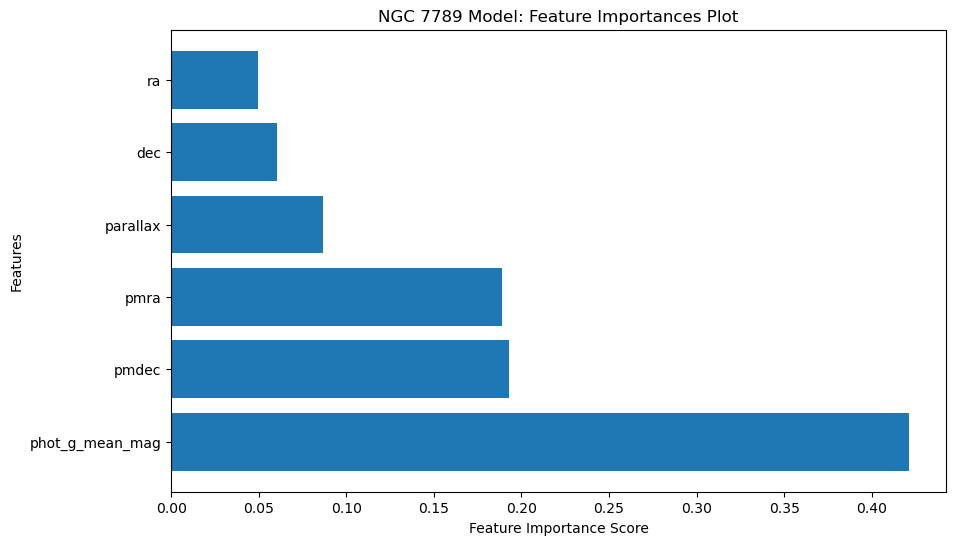

In [33]:
feature_names = ngc_X_train_2.columns  
importances = tuned_xgb_model.named_steps['classifier'].feature_importances_

sorted_idx = importances.argsort()[::-1]

sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_importances = importances[sorted_idx]

plt.figure(figsize = (10, 6))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('NGC 7789 Model: Feature Importances Plot')
plt.show()


***

### Trumpler 5 Star Cluster Members Classification

In [34]:
trumpler_5_filtered = trumpler_5.copy()

In [35]:
## Removing redundant column 'source_id' 
trumpler_5_filtered = trumpler_5_filtered.drop(['radial_velocity', 'source_id'], axis = 1)
trumpler_5_filtered.shape

(3302, 11)

In [36]:
trumpler_5_filtered.head()

,ra,dec,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,teff_gspphot,Cluster
0,99.180263,8.938090,0.117289,-0.767038,0.202383,17.720343,18.314255,16.970951,1.343304,5201.7600,Other
1,99.123816,8.924983,-0.052569,0.351594,-0.838942,17.792180,18.782574,16.812962,1.969612,4615.8970,Other
2,99.161032,8.937259,0.354193,-0.229926,-0.055456,16.855852,17.416264,16.147139,1.269125,5466.8804,Other
3,99.175908,8.955257,0.423364,0.278428,-0.069258,17.581598,18.265062,16.802801,1.462261,5164.1900,Other
4,99.104969,8.958145,0.333585,-0.597968,-0.295040,17.811178,18.439910,17.031984,1.407927,4466.0156,Other


In [37]:
## Creating train and test sets
t5_train_val, t5_test = train_test_split(trumpler_5_filtered, test_size = 0.20, random_state = 309)
print(t5_train_val.shape, t5_test.shape)

(2641, 11) (661, 11)


In [38]:
## Creating validation set from training set
t5_train, t5_val = train_test_split(t5_train_val, test_size = 0.20, random_state = 309)
print(t5_train.shape, t5_val.shape)

(2112, 11) (529, 11)


In [39]:
target = 'Cluster'
t5_X_train = t5_train.drop(target, axis=1) 
t5_y_train = t5_train[target].copy() 

t5_X_val = t5_val.drop(target, axis=1) 
t5_y_val = t5_val[target].copy() 

t5_X_test = t5_test.drop(target, axis=1) 
t5_y_test = t5_test[target].copy() 

print(t5_X_train.shape, t5_y_train.shape, t5_X_val.shape, t5_y_val.shape, t5_X_test.shape, t5_y_test.shape)

(2112, 10) (2112,) (529, 10) (529,) (661, 10) (661,)


In [40]:
def t5_xgb_transform(X, y, synthetic_sampling = True):
    '''XGBoost preprocessing and model fitting custom function'''
    
    numerical_columns = ["ra", "dec", "parallax", "pmra", "pmdec", "phot_g_mean_mag", "phot_bp_mean_mag", "phot_rp_mean_mag", "bp_rp", "teff_gspphot"]

    numerical_preprocessor = Pipeline([('scaler', StandardScaler()),
                                       ('imputer', SimpleImputer(strategy = 'median'))])

    preprocessor = ColumnTransformer([
        ('scaler-and-imputer', numerical_preprocessor, numerical_columns),
    ])

    xgb_label_encoder = LabelEncoder()
    y = xgb_label_encoder.fit_transform(y)


    if synthetic_sampling == True:
        xgb_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ("over", SMOTE(sampling_strategy = 0.80, random_state = 309)),
            ("under", RandomUnderSampler(sampling_strategy = 1.0, random_state = 309)),
            ('classifier', XGBClassifier(objective = 'binary:logistic', random_state = 309))
        ])

    else:
        xgb_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(objective = 'binary:logistic', random_state = 309))
        ])

    model = xgb_pipeline.fit(X, y)

    return(model, xgb_label_encoder)

**Model training and evaluation**

Using all features

In [41]:
## Performance of model on training data, validation data, without synthetic sampling
t5_xgb_model = t5_xgb_transform(t5_X_train, t5_y_train, synthetic_sampling = False)
print("Training Data Performance")
model_performance(t5_xgb_model[0], t5_X_train, t5_y_train, label_enc = t5_xgb_model[1])
print("")
print("Validation Data Performance")
model_performance(t5_xgb_model[0], t5_X_val, t5_y_val, label_enc = t5_xgb_model[1])

Training Data Performance


AUC-ROC: 0.8368 +/- 0.0195
AUC_PR: 0.6495 +/- 0.0399

Validation Data Performance
AUC-ROC: 0.8449 +/- 0.0598
AUC_PR: 0.6704 +/- 0.1010


In [42]:
## Performance of model on training data, validation data, with synthetic sampling
t5_xgb_model = t5_xgb_transform(t5_X_train, t5_y_train, synthetic_sampling = True)
print("Training Data Performance")
model_performance(t5_xgb_model[0], t5_X_train, t5_y_train, label_enc = t5_xgb_model[1])
print("")
print("Validation Data Performance")
model_performance(t5_xgb_model[0], t5_X_val, t5_y_val, label_enc = t5_xgb_model[1])

Training Data Performance
AUC-ROC: 0.8387 +/- 0.0131
AUC_PR: 0.6558 +/- 0.0239

Validation Data Performance
AUC-ROC: 0.8500 +/- 0.0533
AUC_PR: 0.7086 +/- 0.0695


Removing all correlated features, except *phot_g_mean_mag*

In [43]:
def t5_xgb_transform_2(X, y, synthetic_sampling = True):
    '''XGBoost preprocessing and model fitting custom function'''
    
    numerical_columns = ["ra", "dec", "parallax", "pmra", "pmdec", "phot_g_mean_mag"]
    
    numerical_preprocessor = Pipeline([('scaler', StandardScaler()),
                                       ('imputer', SimpleImputer(strategy = 'median'))])

    preprocessor = ColumnTransformer([
        ('scaler-and-imputer', numerical_preprocessor, numerical_columns),
    ])

    xgb_label_encoder = LabelEncoder()
    y = xgb_label_encoder.fit_transform(y)


    if synthetic_sampling == True:
        xgb_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ("over", SMOTE(sampling_strategy = 0.80, random_state = 309)),
            ("under", RandomUnderSampler(sampling_strategy = 1.0, random_state = 309)),
            ('classifier', XGBClassifier(objective = 'binary:logistic', random_state = 309))
        ])

    else:
        xgb_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(objective = 'binary:logistic', random_state = 309))
        ])

    model = xgb_pipeline.fit(X, y)

    return(model, xgb_label_encoder)

In [44]:
t5_X_train_2 = t5_X_train.drop(["phot_bp_mean_mag", "phot_rp_mean_mag", "bp_rp", "teff_gspphot"], axis = 1)
t5_X_val_2 = t5_X_val.drop(["phot_bp_mean_mag", "phot_rp_mean_mag", "bp_rp", "teff_gspphot"], axis = 1)

In [45]:
## Performance of model on training data, validation data, without synthetic sampling
t5_xgb_model_2 = t5_xgb_transform_2(t5_X_train_2, t5_y_train, synthetic_sampling = False)
print("Training Data Performance")
model_performance(t5_xgb_model_2[0], t5_X_train_2, t5_y_train, label_enc = t5_xgb_model_2[1])
print("")
print("Validation Data Performance")
model_performance(t5_xgb_model_2[0], t5_X_val_2, t5_y_val, label_enc = t5_xgb_model_2[1])

Training Data Performance
AUC-ROC: 0.8308 +/- 0.0188
AUC_PR: 0.6416 +/- 0.0328

Validation Data Performance
AUC-ROC: 0.8260 +/- 0.0457
AUC_PR: 0.6205 +/- 0.0597


In [46]:
## Performance of model on training data, validation data, with synthetic sampling
t5_xgb_model_2 = t5_xgb_transform_2(t5_X_train_2, t5_y_train, synthetic_sampling = True)
print("Training Data Performance")
model_performance(t5_xgb_model_2[0], t5_X_train_2, t5_y_train, label_enc = t5_xgb_model_2[1])
print("")
print("Validation Data Performance")
model_performance(t5_xgb_model_2[0], t5_X_val_2, t5_y_val, label_enc = t5_xgb_model_2[1])

Training Data Performance
AUC-ROC: 0.8265 +/- 0.0132
AUC_PR: 0.6315 +/- 0.0269

Validation Data Performance
AUC-ROC: 0.8323 +/- 0.0386
AUC_PR: 0.6430 +/- 0.0635


Removing all correlated features, except *phot_g_mean_mag* and *teff_gspphot*

In [47]:
def t5_xgb_transform_3(X, y, synthetic_sampling = True):
    '''XGBoost preprocessing and model fitting custom function'''
    
    numerical_columns = ["ra", "dec", "parallax", "pmra", "pmdec", "phot_g_mean_mag", "teff_gspphot"]
    
    numerical_preprocessor = Pipeline([('scaler', StandardScaler()),
                                       ('imputer', SimpleImputer(strategy = 'median'))])

    preprocessor = ColumnTransformer([
        ('scaler-and-imputer', numerical_preprocessor, numerical_columns),
    ])

    xgb_label_encoder = LabelEncoder()
    y = xgb_label_encoder.fit_transform(y)


    if synthetic_sampling == True:
        xgb_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ("over", SMOTE(sampling_strategy = 0.80, random_state = 309)),
            ("under", RandomUnderSampler(sampling_strategy = 1.0, random_state = 309)),
            ('classifier', XGBClassifier(objective = 'binary:logistic', random_state = 309))
        ])

    else:
        xgb_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(objective = 'binary:logistic', random_state = 309))
        ])

    model = xgb_pipeline.fit(X, y)

    return(model, xgb_label_encoder)

In [48]:
t5_X_train_3 = t5_X_train.drop(["phot_bp_mean_mag", "phot_rp_mean_mag", "bp_rp"], axis = 1)
t5_X_val_3 = t5_X_val.drop(["phot_bp_mean_mag", "phot_rp_mean_mag", "bp_rp"], axis = 1)

In [49]:
## Performance of model on training data, validation data, without synthetic sampling
t5_xgb_model_3 = t5_xgb_transform_3(t5_X_train_3, t5_y_train, synthetic_sampling = False)
print("Training Data Performance")
model_performance(t5_xgb_model_3[0], t5_X_train_3, t5_y_train, label_enc = t5_xgb_model_3[1])
print("")
print("Validation Data Performance")
model_performance(t5_xgb_model_3[0], t5_X_val_3, t5_y_val, label_enc = t5_xgb_model_3[1])

Training Data Performance
AUC-ROC: 0.8351 +/- 0.0210
AUC_PR: 0.6464 +/- 0.0369

Validation Data Performance
AUC-ROC: 0.8310 +/- 0.0538
AUC_PR: 0.6517 +/- 0.0769


In [50]:
## Performance of model on training data, validation data, with synthetic sampling
t5_xgb_model_3 = t5_xgb_transform_3(t5_X_train_3, t5_y_train, synthetic_sampling = True)
print("Training Data Performance")
model_performance(t5_xgb_model_3[0], t5_X_train_3, t5_y_train, label_enc = t5_xgb_model_3[1])
print("")
print("Validation Data Performance")
model_performance(t5_xgb_model_3[0], t5_X_val_3, t5_y_val, label_enc = t5_xgb_model_3[1])

Training Data Performance
AUC-ROC: 0.8332 +/- 0.0129
AUC_PR: 0.6460 +/- 0.0203

Validation Data Performance
AUC-ROC: 0.8409 +/- 0.0404
AUC_PR: 0.6700 +/- 0.0503


**Tuning XGB Model 1, synthetic sampling**

In [51]:
numerical_columns = ["ra", "dec", "parallax", "pmra", "pmdec", "phot_g_mean_mag", "phot_bp_mean_mag", "phot_rp_mean_mag", "bp_rp", "teff_gspphot"]

numerical_preprocessor = Pipeline([('scaler', StandardScaler()),
                                    ('imputer', SimpleImputer(strategy = 'median'))])

preprocessor = ColumnTransformer([
    ('scaler-and-imputer', numerical_preprocessor, numerical_columns),
])

xgb_label_encoder = LabelEncoder()
t5_y_train_enc = xgb_label_encoder.fit_transform(t5_y_train)

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ("over", SMOTE(sampling_strategy = 0.80, random_state = 309)),
    ("under", RandomUnderSampler(sampling_strategy = 1.0, random_state = 309)),
    ('classifier', XGBClassifier(objective = 'binary:logistic', random_state = 309))
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.1, 0.01, 0.001]
}

gridSearch = GridSearchCV(xgb_model, param_grid, cv = 5, scoring = 'average_precision', return_train_score = True)
gridSearch.fit(t5_X_train, t5_y_train_enc)

print("Best parameters:", gridSearch.best_params_)
tuned_xgb_model = gridSearch.best_estimator_

Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}


In [52]:
## Model performance on validation set
model_performance(tuned_xgb_model, t5_X_val, t5_y_val, label_enc = xgb_label_encoder)

AUC-ROC: 0.8611 +/- 0.0430
AUC_PR: 0.6809 +/- 0.0671


In [53]:
## Model performance on test set
tuned_perf = model_performance(tuned_xgb_model, t5_X_test, t5_y_test, label_enc = xgb_label_encoder, predictions = True)

AUC-ROC: 0.8651 +/- 0.0388
AUC_PR: 0.7152 +/- 0.0662


In [54]:
t5_y_test

125          Other
889          Other
552          Other
853          Other
3049         Other
           ...    
2743    Trumpler_5
1361         Other
2327         Other
1784         Other
2862         Other
Name: Cluster, Length: 661, dtype: object

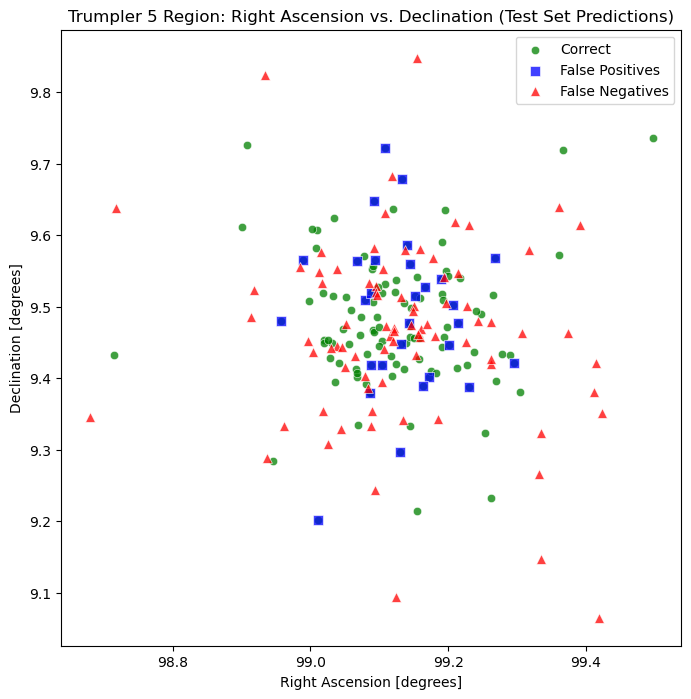

In [55]:
model_predictions = xgb_label_encoder.fit_transform(tuned_perf)
t5_y_test_enc = xgb_label_encoder.fit_transform(t5_y_test)

predictions_data = pd.DataFrame({
    'ra': t5_X_test['ra'],
    'dec': t5_X_test['dec'],
    'prediction': model_predictions
})

plt.figure(figsize = (8, 8))

# Correctly classified points in blue
sns.scatterplot(x = 'ra', y = 'dec', data = predictions_data[predictions_data['prediction'] == 1], color = 'green', alpha = 0.75, label = 'Correct')

# False positives (squares)
false_positives = predictions_data[(predictions_data['prediction'] == 1) & (t5_y_test_enc == 0)]
sns.scatterplot(x = 'ra', y = 'dec', data = false_positives, color = 'blue', marker = 's', s = 50, alpha = 0.75, label = 'False Positives')

# False negatives (triangles)
false_negatives = predictions_data[(predictions_data['prediction'] == 0) & (t5_y_test_enc == 1)]
sns.scatterplot(x = 'ra', y = 'dec', data = false_negatives, color = 'red', marker = '^', s = 50, alpha = 0.75, label = 'False Negatives')

plt.xlabel('Right Ascension [degrees]')
plt.ylabel('Declination [degrees]')
plt.title('Trumpler 5 Region: Right Ascension vs. Declination (Test Set Predictions)')
plt.legend()
plt.show()

In [56]:
len(false_negatives)

83

In [57]:
len(false_positives)

29

In [58]:
feature_names

Index(['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'phot_g_mean_mag'], dtype='object')

In [59]:
t5_importances

NameError: name 't5_importances' is not defined

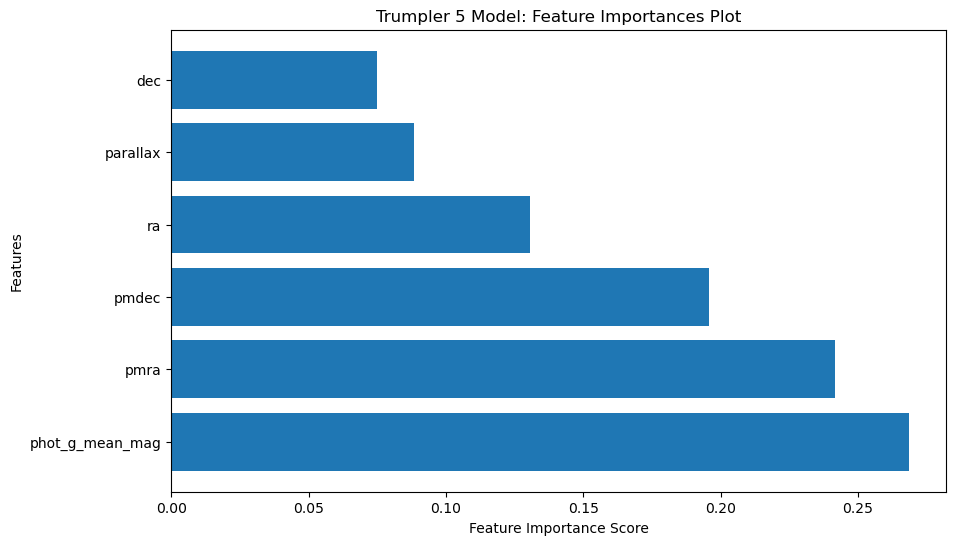

In [ ]:
feature_names = t5_X_train.columns  
importances = tuned_xgb_model.named_steps['classifier'].feature_importances_
sorted_idx = importances.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_importances = importances[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Trumpler 5 Model: Feature Importances Plot')
plt.show()
